# Load packages and model

In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

from PIL import Image

import torch
import torch.nn.functional as F

import sys
sys.path.insert(1, os.path.join(sys.path[0], '../utils'))

import argparse
import librosa

import warnings
warnings.filterwarnings("ignore")

from utilities import create_folder, get_filename
from models import *
from pytorch_utils import move_data_to_device
import config

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

# Model
model_type = "Cnn14_nnAudio_gf"
checkpoint_path = "/root/autodl-nas/cnn/checkpoints/main/holdout_fold=4/Cnn14_nnAudio_gf/feature=log-stft/loss_type=clip_bce/batch_size=16/8000_iterations.pth"
Model = eval(model_type)
model = Model(sample_rate=config.sample_rate, window_size=config.window_size, 
    hop_size=config.hop_size, mel_bins=config.mel_bins, fmin=config.fmin, fmax=config.fmax, 
    classes_num=config.classes_num)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'])

# Parallel
if 'cuda' in str(device):
    model.to(device)
    print('GPU number: {}'.format(torch.cuda.device_count()))
    model = torch.nn.DataParallel(model)
else:
    print('Using CPU.')

device cuda:0
STFT kernels created, time used = 0.0205 seconds
STFT filter created, time used = 0.0015 seconds
Mel filter created, time used = 0.0015 seconds
GPU number: 1


# Test1, ShipsEar Dataset

In [2]:
df = pd.read_excel('/root/autodl-nas/cnn/data/shipsEar_AUDIOS-20221110T120256Z-001/shipsEar_AUDIOS/shipsEar.xlsx')
df_pred = pd.DataFrame()
n = 0
for idx, row in tqdm(df.iterrows()):
    audio_name = row['Filename']
    audio_path = '/root/autodl-nas/cnn/data/shipsEar_AUDIOS-20221110T120256Z-001/shipsEar_AUDIOS/' +audio_name
    (waveform, _) = librosa.core.load(audio_path, sr=config.sample_rate, mono=True)
    waveform = waveform[None, :]    # (1, audio_length)
    waveform = move_data_to_device(waveform, device)
    # Forward
    with torch.no_grad():
        model.eval()
        batch_output_dict = model(waveform, None)
    clipwise_output = batch_output_dict['clipwise_output'].data.cpu().numpy()[0]
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    pred_dict = {}
    # top-n 预测结果
    for k in range(4):
        pred_dict['top-{}-预测ID'.format(k+1)] = sorted_indexes[k]
    # 每个类别的预测置信度
    for k in range(4):
        pred_dict['{}-预测置信度'.format(np.array(config.labels)[sorted_indexes[k]])] = clipwise_output[sorted_indexes[k]]
    df_pred = df_pred.append(pred_dict, ignore_index=True)

90it [07:27,  4.98s/it]


In [3]:
df_pred

,top-1-预测ID,top-2-预测ID,top-3-预测ID,top-4-预测ID,Passengership-预测置信度,Tanker-预测置信度,Tug-预测置信度,Cargo-预测置信度
0,1.0,2.0,3.0,0.0,0.984777,0.009601,0.007445,0.000595
1,1.0,3.0,0.0,2.0,0.960987,0.004516,0.041990,0.010857
2,1.0,2.0,3.0,0.0,0.974777,0.019948,0.010354,0.001302
3,1.0,2.0,3.0,0.0,0.984716,0.012856,0.006531,0.001494
4,1.0,3.0,0.0,2.0,0.917640,0.020247,0.067301,0.037028
...,...,...,...,...,...,...,...,...
85,1.0,2.0,0.0,3.0,0.817153,0.281753,0.000641,0.011294
86,3.0,1.0,2.0,0.0,0.068647,0.000212,0.942478,0.000142
87,2.0,0.0,1.0,3.0,0.008915,0.869812,0.003084,0.135951
88,3.0,1.0,0.0,2.0,0.387594,0.042591,0.534438,0.196867


In [4]:
df = pd.concat([df, df_pred], axis=1)

In [5]:
df

,ID,Filename,Name,Type,Pic,Date,H_G_D,Video,Channel Depth,Wind,...,Duration,Notes,top-1-预测ID,top-2-预测ID,top-3-预测ID,top-4-预测ID,Passengership-预测置信度,Tanker-预测置信度,Tug-预测置信度,Cargo-预测置信度
0,80,80__04_10_12_adricristuy.wav,Adricristuy,Dredger,https://atlanttic.uvigo.es/underwaternoise/fot...,2012-10-04 14:00:00,"(3),(16),(5)",No,20.0,Not available,...,1:00,Dredger Adricristuy recording during Punta Lan...,1.0,2.0,3.0,0.0,0.984777,0.009601,0.007445,0.000595
1,10,10__10_07_13_marDeOnza_Sale.wav,Mar de Onza (Leaving),Passengers,https://atlanttic.uvigo.es/underwaternoise/fot...,2013-07-10 00:00:00,"(2),(4),(2.85)",NO,4.8,0,...,2:34,First series of recordings. There is not in si...,1.0,3.0,0.0,2.0,0.960987,0.004516,0.041990,0.010857
2,14,14__10_07_13_piraCies_Espera.wav,Pirata de Cies (Waiting),Passengers,https://atlanttic.uvigo.es/underwaternoise/fot...,2013-07-10 00:00:00,"(2),(4),(2.85)",No,4.8,0,...,1:00,First series of recordings. There is not in si...,1.0,2.0,3.0,0.0,0.974777,0.019948,0.010354,0.001302
3,15,15__10_07_13_radaUno_Pasa.wav,Rada Uno (Passing),Tugboat,https://atlanttic.uvigo.es/underwaternoise/fot...,2013-07-10 00:00:00,"(2),(4),(2.85)",NO,9.1,0,...,2:22,First series of recordings. There is not in si...,1.0,2.0,3.0,0.0,0.984716,0.012856,0.006531,0.001494
4,6,6__10_07_13_marDeCangas_Entra.wav,Mar de Cangas (Entering),Passengers,https://atlanttic.uvigo.es/underwaternoise/fot...,2013-07-10 12:19:00,"(2),(4),(2.85)",NO,4.8,0,...,5:01,First series of recordings. There is not in si...,1.0,3.0,0.0,2.0,0.917640,0.020247,0.067301,0.037028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,84,84__27_09_13_H3_viento.wav,Maximum wind,Natural ambient noise,https://atlanttic.uvigo.es/underwaternoise/fot...,2013-09-27 05:06:00,(1)(64)(4.5),No,7.5,12.21,...,2:00,Natural ambient noise measurement in Cortegada...,1.0,2.0,0.0,3.0,0.817153,0.281753,0.000641,0.011294
86,93,93__A__Draga_1.wav,Moanha tests sample 1,Dredger,https://atlanttic.uvigo.es/underwaternoise/fot...,2014-03-06 00:00:00,"(3),(16),(5)",No,12.0,Not available,...,0:30,Dredger Adricristuy recording during Moanha me...,3.0,1.0,2.0,0.0,0.068647,0.000212,0.942478,0.000142
87,94,94__A__Draga_2.wav,Moanha tests sample 2,Dredger,https://atlanttic.uvigo.es/underwaternoise/fot...,2014-03-06 00:00:00,"(2),(16),(5)",No,12.0,Not available,...,0:50,Dredger Adricristuy recording during Moanha me...,2.0,0.0,1.0,3.0,0.008915,0.869812,0.003084,0.135951
88,95,95__A__Draga_3.wav,Moanha tests sample 3,Dredger,https://atlanttic.uvigo.es/underwaternoise/fot...,2014-03-06 00:00:00,"(2),(16),(5)",No,12.0,Not available,...,1:00,Dredger Adricristuy recording during Moanha me...,3.0,1.0,0.0,2.0,0.387594,0.042591,0.534438,0.196867


In [6]:
df.to_csv('ShipsEar预测结果.csv', index=False)

# Test2, DeepShip_fold4 Dataset

In [7]:
from evaluate import Evaluator
from data_generator import Dataset, TrainSampler, EvaluateSampler, collate_fn

evaluator = Evaluator(model=model)
num_workers = 8
hdf5_path = "/root/autodl-nas/cnn/data/waveform.h5"
holdout_fold = 4
batch_size = 16
set_indexes = False

dataset = Dataset()
validate_sampler = EvaluateSampler(
    hdf5_path=hdf5_path, 
    holdout_fold=holdout_fold, 
    batch_size=batch_size,
    set_indexes=set_indexes)
validate_loader = torch.utils.data.DataLoader(dataset=dataset, 
    batch_sampler=validate_sampler, collate_fn=collate_fn, 
    num_workers=num_workers, pin_memory=True)

In [32]:
df2_pred = pd.DataFrame()
for i in tqdm(validate_loader):
    waveform = move_data_to_device(i['waveform'], device)
    test = i
    # Forward
    with torch.no_grad():
        model.eval()
        batch_output_dict = model(waveform, None)
    clipwise_outputs = batch_output_dict['clipwise_output'].data.cpu().numpy()
    for idx, clipwise_output in enumerate(clipwise_outputs):
        pred_dict = {}
        pred_dict['音频名'] = i['audio_name'][idx]
        pred_dict['真实值'] = i['target'][idx].tolist().index(1)
        sorted_indexes = np.argsort(clipwise_output)[::-1]
        # top-n 预测结果
        for k in range(4):
            pred_dict['top-{}-预测ID'.format(k+1)] = sorted_indexes[k]
        # 每个类别的预测置信度
        for k in range(4):
            pred_dict['{}-预测置信度'.format(np.array(config.labels)[sorted_indexes[k]])] = clipwise_output[sorted_indexes[k]]
        df2_pred = df2_pred.append(pred_dict, ignore_index=True)

178it [00:28,  6.35it/s]


In [33]:
df2_pred.to_csv('DeepShip_fold4预测结果.csv', index=False)

# Confused Matrix

In [63]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
#!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
#!rm -rf /home/featurize/.cache/matplotlib

import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [64]:
# 获得类别名称
classes = list(config.labels)
print(classes)

['Cargo', 'Passengership', 'Tanker', 'Tug']


In [65]:
df = pd.read_csv('DeepShip_fold4预测结果.csv')
df.head()

,音频名,真实值,top-1-预测ID,top-2-预测ID,top-3-预测ID,top-4-预测ID,Tanker-预测置信度,Cargo-预测置信度,Passengership-预测置信度,Tug-预测置信度
0,4.wav,0,2,0,1,3,0.749883,0.265009,0.041954,0.004316
1,4.wav,0,0,2,1,3,0.107955,0.878018,0.035214,0.006016
2,4.wav,0,0,2,1,3,0.121546,0.831802,0.064866,0.002033
3,4.wav,0,0,2,1,3,0.303824,0.706913,0.033576,0.001492
4,4.wav,0,0,2,1,3,0.085848,0.918323,0.009773,0.003644


In [66]:
from sklearn.metrics import confusion_matrix

confusion_matrix_model = confusion_matrix(df['真实值'], df['top-1-预测ID'])

In [67]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('confused matrix', fontsize=30)
    plt.xlabel('predict', fontsize=25, c='r')
    plt.ylabel('target', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=0) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

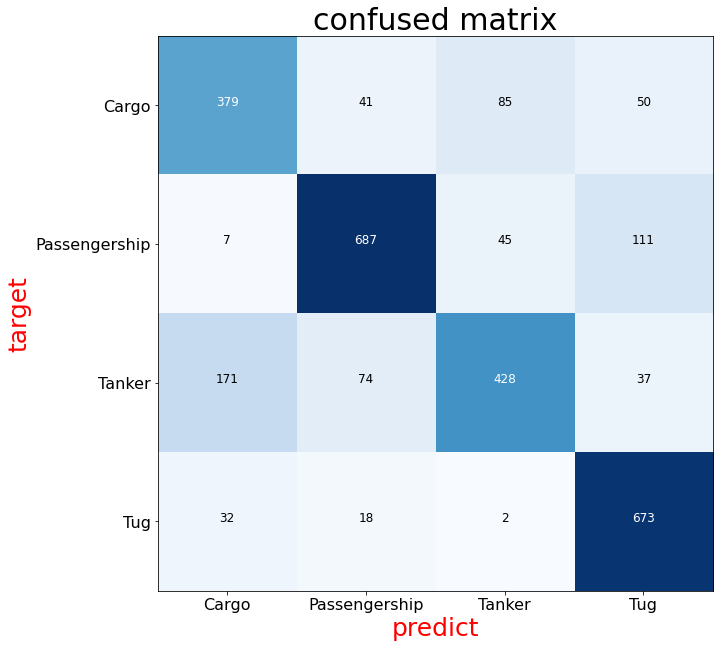

In [68]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

# 绘制所有类别的ROC曲线

In [69]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

In [70]:
def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

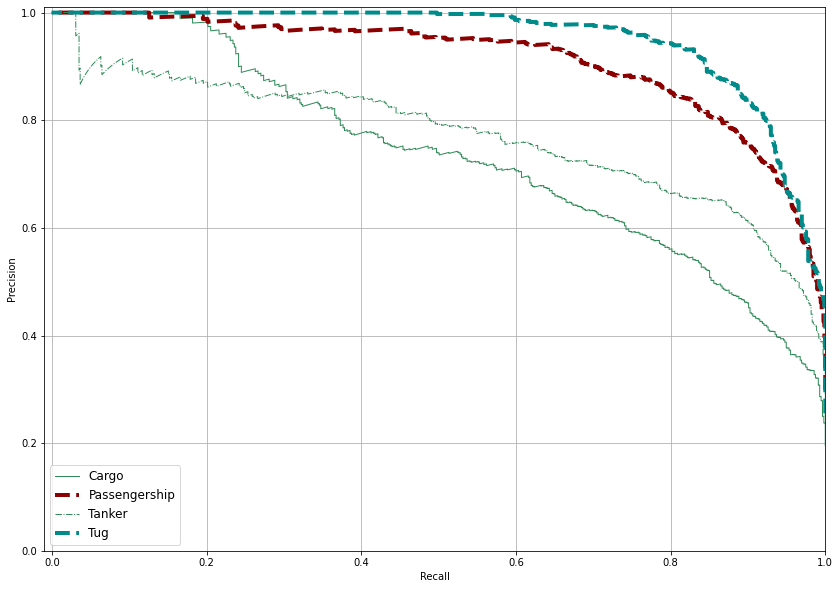

In [71]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(14, 10))
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
# plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='随机模型')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.rcParams['font.size'] = 22
plt.grid(True)

ap_list = []
for each_class in classes:
    y_test = list((df['真实值'] == config.lb_to_idx[each_class]))
    y_score = list(df['{}-预测置信度'.format(each_class)])
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    AP = average_precision_score(y_test, y_score, average='weighted')
    plt.plot(recall, precision, **get_line_arg(), label=each_class)
    plt.legend()
    ap_list.append(AP)

plt.legend(loc='best', fontsize=12)
plt.savefig('各类别PR曲线.pdf', dpi=120, bbox_inches='tight')
plt.show()

# 各类别其它评估指标

In [72]:
from sklearn.metrics import classification_report

print(classification_report(df['真实值'], df['top-1-预测ID'], target_names=classes))

               precision    recall  f1-score   support

        Cargo       0.64      0.68      0.66       555
Passengership       0.84      0.81      0.82       850
       Tanker       0.76      0.60      0.67       710
          Tug       0.77      0.93      0.84       725

     accuracy                           0.76      2840
    macro avg       0.75      0.76      0.75      2840
 weighted avg       0.76      0.76      0.76      2840



In [73]:
report = classification_report(df['真实值'], df['top-1-预测ID'], target_names=classes, output_dict=True)
del report['accuracy']
df_report = pd.DataFrame(report).transpose()

In [74]:
df_report

,precision,recall,f1-score,support
Cargo,0.643463,0.682883,0.662587,555.0
Passengership,0.837805,0.808235,0.822754,850.0
Tanker,0.764286,0.602817,0.674016,710.0
Tug,0.772675,0.928276,0.843358,725.0
macro avg,0.754557,0.755553,0.750679,2840.0
weighted avg,0.764820,0.763028,0.759529,2840.0


In [75]:
accuracy_list = []
for ship in range(4):
    df_temp = df[df['真实值']==ship]
    accuracy = sum(df_temp['真实值'] == df_temp['top-1-预测ID']) / len(df_temp)
    accuracy_list.append(accuracy)

In [76]:
# 计算 宏平均准确率 和 加权平均准确率
acc_macro = np.mean(accuracy_list)
acc_weighted = sum(accuracy_list * df_report.iloc[:-2]['support'] / len(df))

accuracy_list.append(acc_macro)
accuracy_list.append(acc_weighted)

df_report['accuracy'] = accuracy_list

In [77]:
df_report

,precision,recall,f1-score,support,accuracy
Cargo,0.643463,0.682883,0.662587,555.0,0.682883
Passengership,0.837805,0.808235,0.822754,850.0,0.808235
Tanker,0.764286,0.602817,0.674016,710.0,0.602817
Tug,0.772675,0.928276,0.843358,725.0,0.928276
macro avg,0.754557,0.755553,0.750679,2840.0,0.755553
weighted avg,0.764820,0.763028,0.759529,2840.0,0.763028


In [78]:
# 计算 AUC值 的 宏平均 和 加权平均
macro_avg_auc = np.mean(ap_list)
weighted_avg_auc = sum(ap_list * df_report.iloc[:-2]['support'] / len(df))
ap_list.append(macro_avg_auc)
ap_list.append(weighted_avg_auc)
df_report['AP'] = ap_list
df_report

,precision,recall,f1-score,support,accuracy,AP
Cargo,0.643463,0.682883,0.662587,555.0,0.682883,0.735685
Passengership,0.837805,0.808235,0.822754,850.0,0.808235,0.911260
Tanker,0.764286,0.602817,0.674016,710.0,0.602817,0.771487
Tug,0.772675,0.928276,0.843358,725.0,0.928276,0.951277
macro avg,0.754557,0.755553,0.750679,2840.0,0.755553,0.842427
weighted avg,0.764820,0.763028,0.759529,2840.0,0.763028,0.852221


# 绘制所有类别的ROC曲线

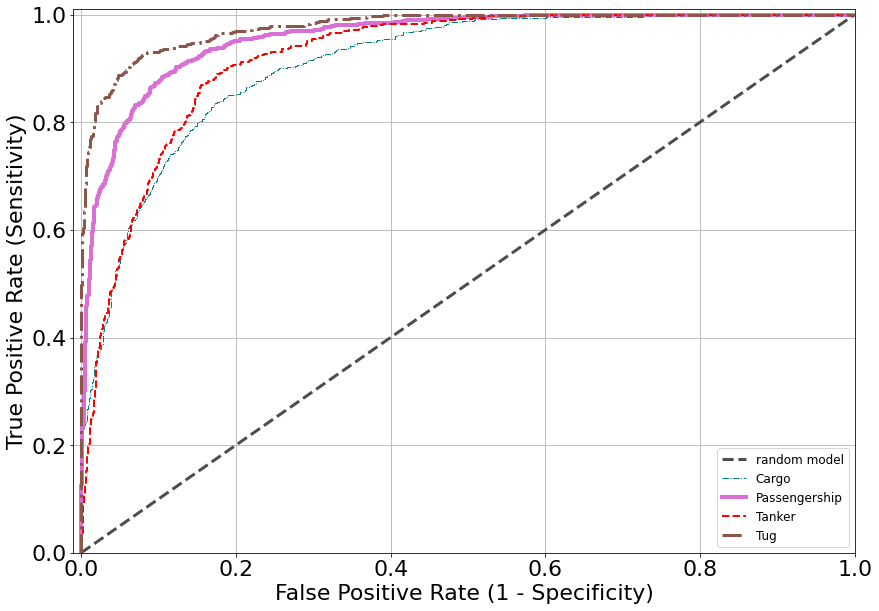

In [79]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(14, 10))
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.plot([0, 1], [0, 1],ls="--", c='.3', linewidth=3, label='random model')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.rcParams['font.size'] = 22
plt.grid(True)

auc_list = []
for each_class in classes:
    y_test = list((df['真实值'] == config.lb_to_idx[each_class]))
    y_score = list(df['{}-预测置信度'.format(each_class)])
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, **get_line_arg(), label=each_class)
    plt.legend()
    auc_list.append(auc(fpr, tpr))

plt.legend(loc='best', fontsize=12)
plt.savefig('各类别ROC曲线.pdf', dpi=120, bbox_inches='tight')
plt.show()

# 将AUC增加至各类别准确率评估指标表格中

In [80]:
# 计算 AUC值 的 宏平均 和 加权平均
macro_avg_auc = np.mean(auc_list)
weighted_avg_auc = sum(auc_list * df_report.iloc[:-2]['support'] / len(df))
auc_list.append(macro_avg_auc)
auc_list.append(weighted_avg_auc)
df_report['AUC'] = auc_list
df_report

,precision,recall,f1-score,support,accuracy,AP,AUC
Cargo,0.643463,0.682883,0.662587,555.0,0.682883,0.735685,0.908691
Passengership,0.837805,0.808235,0.822754,850.0,0.808235,0.911260,0.957250
Tanker,0.764286,0.602817,0.674016,710.0,0.602817,0.771487,0.921229
Tug,0.772675,0.928276,0.843358,725.0,0.928276,0.951277,0.977711
macro avg,0.754557,0.755553,0.750679,2840.0,0.755553,0.842427,0.941220
weighted avg,0.764820,0.763028,0.759529,2840.0,0.763028,0.852221,0.943978


In [81]:
df_report.to_csv('各类别准确率评估指标.csv', index='class')

# 绘制各类别准确率评估指标柱状图

In [82]:
# feature = 'precision'
# feature = 'recall'
# feature = 'f1-score'
feature = 'accuracy'
# feature = 'AP'
# feature = 'AUC'
df = df_report

In [86]:
df_plot = df.sort_values(by=feature, ascending=False)
df_plot.reset_index(inplace=True)
df_plot

,index,precision,recall,f1-score,support,accuracy,AP,AUC
0,Tug,0.772675,0.928276,0.843358,725.0,0.928276,0.951277,0.977711
1,Passengership,0.837805,0.808235,0.822754,850.0,0.808235,0.911260,0.957250
2,weighted avg,0.764820,0.763028,0.759529,2840.0,0.763028,0.852221,0.943978
3,macro avg,0.754557,0.755553,0.750679,2840.0,0.755553,0.842427,0.941220
4,Cargo,0.643463,0.682883,0.662587,555.0,0.682883,0.735685,0.908691
5,Tanker,0.764286,0.602817,0.674016,710.0,0.602817,0.771487,0.921229


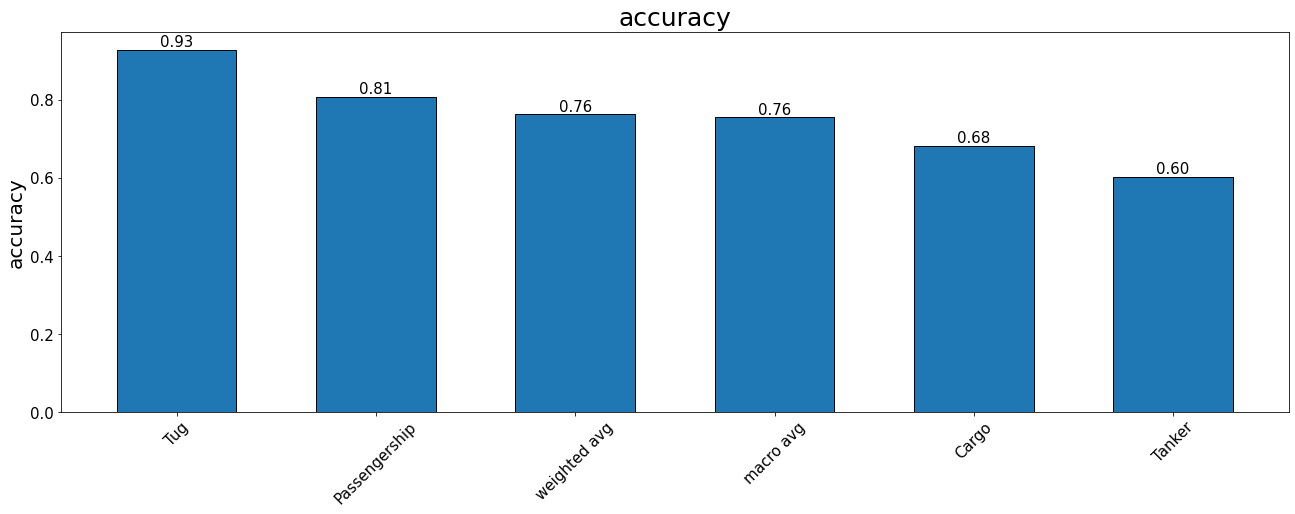

In [88]:
plt.figure(figsize=(22, 7))

x = df_plot['index']
y = df_plot[feature]

ax = plt.bar(x, y, width=0.6, facecolor='#1f77b4', edgecolor='k')
plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值

plt.xticks(rotation=45)
plt.tick_params(labelsize=15)
# plt.xlabel('类别', fontsize=20)
plt.ylabel(feature, fontsize=20)
plt.title('{}'.format(feature), fontsize=25)

plt.savefig('各类别准确率评估指标柱状图-{}.pdf'.format(feature), dpi=120, bbox_inches='tight')

plt.show()